In [1]:
# import required modules for preprocessing
import os
from os.path import join
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords as Stopwords
from scipy.sparse import csr_matrix

# import required modules for classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# import required modules for RNN classification
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

---
## Load training set, dev set and testing set

In [3]:
# Load training set, dev set and testing set

dataDir = '../semeval-tweets'  # change to the proper directory
#datasetStrings = ['twitter-training-data.txt', 'twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt', 'twitter-dev-data.txt']
datasetStrings = ['twitter-training-data.txt', 'twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt', 'twitter-test4.txt', 'twitter-test5.txt', 'twitter-dev-data.txt']


datasets = [join(dataDir, t) for t in datasetStrings]

if len(datasets)==5:
    print(f"Extracting data from: \n\t{datasets[0]}\n\t{datasets[1]}\n\t{datasets[2]}\n\t{datasets[3]}\n\t{datasets[4]}")
    tweet_IDs = {}          # init dictionary with tweet IDs
    tweet_sentiments = {}   # init dictionary with sentiments
    tweet_texts = {}        # init dictionary with tweet texts
    for DatasetString in datasets:
        data_ID, data_sent, data_text  = {}, {}, {}    # temp dictionaries
        with open(DatasetString, 'r', encoding='utf8') as f1:
            for i, line in enumerate(f1):
                fields = line.split('\t')
                data_ID[i] = fields[0]            # tweet IDs
                data_sent[fields[0]] = fields[1]  # sentiments
                data_text[fields[0]] = fields[2]  # tweet text
        tweet_IDs[DatasetString] = data_ID
        tweet_sentiments[DatasetString] = data_sent
        tweet_texts[DatasetString] = data_text

    # sentiment dictionaries
    sent_train = tweet_sentiments[datasets[0]]
    sent_test1 = tweet_sentiments[datasets[1]]
    sent_test2 = tweet_sentiments[datasets[2]]
    sent_test3 = tweet_sentiments[datasets[3]]
    sent_dev = tweet_sentiments[datasets[4]]

    # tweet text dictionaries
    text_train = tweet_texts[datasets[0]]
    text_test1 = tweet_texts[datasets[1]]
    text_test2 = tweet_texts[datasets[2]]
    text_test3 = tweet_texts[datasets[3]]
    text_dev = tweet_texts[datasets[4]]

    # tweet IDs dictionaries
    IDs_train = tweet_IDs[datasets[0]]
    IDs_test1 = tweet_IDs[datasets[1]]
    IDs_test2 = tweet_IDs[datasets[2]]
    IDs_test3 = tweet_IDs[datasets[3]]
    IDs_dev = tweet_IDs[datasets[4]]

    # saving the sentiments and IDs as a pickle file
    temp = [sent_train, sent_test1, sent_test2, sent_test3, sent_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev]
    with open("preprocessing-sent-ID.pkl", 'wb') as out_file:
        pickle.dump(temp, out_file, protocol=-1)

if len(datasets)==7:
    print(f"Extracting data from: \n\t{datasets[0]}\n\t{datasets[1]}\n\t{datasets[2]}\n\t{datasets[3]}\n\t{datasets[4]}\n\t{datasets[5]}\n\t{datasets[6]}")

    tweet_IDs = {}          # init dictionary with tweet IDs
    tweet_sentiments = {}   # init dictionary with sentiments
    tweet_texts = {}        # init dictionary with tweet texts
    for DatasetString in datasets:
        data_ID, data_sent, data_text  = {}, {}, {}    # temp dictionaries
        with open(DatasetString, 'r', encoding='utf8') as f1:
            for i, line in enumerate(f1):
                fields = line.split('\t')
                data_ID[i] = fields[0]            # tweet IDs
                data_sent[fields[0]] = fields[1]  # sentiments
                data_text[fields[0]] = fields[2]  # tweet text
        tweet_IDs[DatasetString] = data_ID
        tweet_sentiments[DatasetString] = data_sent
        tweet_texts[DatasetString] = data_text

    # sentiment dictionaries
    sent_train = tweet_sentiments[datasets[0]]
    sent_test1 = tweet_sentiments[datasets[1]]
    sent_test2 = tweet_sentiments[datasets[2]]
    sent_test3 = tweet_sentiments[datasets[3]]
    sent_test4 = tweet_sentiments[datasets[4]]
    sent_test5 = tweet_sentiments[datasets[5]]
    sent_dev = tweet_sentiments[datasets[6]]

    # tweet text dictionaries
    text_train = tweet_texts[datasets[0]]
    text_test1 = tweet_texts[datasets[1]]
    text_test2 = tweet_texts[datasets[2]]
    text_test3 = tweet_texts[datasets[3]]
    text_test4 = tweet_texts[datasets[4]]
    text_test5 = tweet_texts[datasets[5]]
    text_dev = tweet_texts[datasets[6]]

    # tweet IDs dictionaries
    IDs_train = tweet_IDs[datasets[0]]
    IDs_test1 = tweet_IDs[datasets[1]]
    IDs_test2 = tweet_IDs[datasets[2]]
    IDs_test3 = tweet_IDs[datasets[3]]
    IDs_test4 = tweet_IDs[datasets[4]]
    IDs_test5 = tweet_IDs[datasets[5]]
    IDs_dev = tweet_IDs[datasets[6]]

    temp = [sent_train, sent_test1, sent_test2, sent_test3, sent_test4,  sent_test5, sent_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_test4, IDs_test5, IDs_dev]
    with open("preprocessing-sent-ID7.pkl", 'wb') as out_file:
        pickle.dump(temp, out_file, protocol=-1)


Extracting data from: 
	../semeval-tweets/twitter-training-data.txt
	../semeval-tweets/twitter-test1.txt
	../semeval-tweets/twitter-test2.txt
	../semeval-tweets/twitter-test3.txt
	../semeval-tweets/twitter-test4.txt
	../semeval-tweets/twitter-test5.txt
	../semeval-tweets/twitter-dev-data.txt


In [4]:
# auxiliary functions

# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    reading the testset and return a dictionary with: ID -> sentiment
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}  # init the dictionary
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]
            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)
    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')
    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}
    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}
    for cat, acc in acc_by_class.items():
        catcount += 1
        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1
        n = acc['tp'] + acc['fn']
        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1
        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1
        itemcount += n
    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)
    return semevalmacrof1

# removing stop words variables
stopwords = Stopwords.words('english')
stopwords = [word.replace('\'', '') for word in stopwords]

# auxiliary ftion which takes list of words and returns its BoW representation as np.array
def text2BOW(text_list, vocabulary, vocab2num, stopwords):
    BOW_vec = np.zeros(len(vocabulary) + 1)
    for word in text_list:
        if not word in stopwords:
            if word in vocabulary:
                BOW_vec[vocab2num[word]-1] += 1
            else:
                BOW_vec[vocab2num['<OOV>']-1] += 1
    return BOW_vec

# auxiliary ftion which takes list of words and returns its TFIDF representation as np.array
def text2TFIDF(text_list, vocabulary, vocab2num, stopwords, DFfreq, Ntexts):
    TFIDF_vec = np.zeros(len(vocabulary) + 1)
    for word in np.unique(text_list):
        if not word in stopwords:
            if word in vocabulary:
                if DFfreq[word] == 0:    ###
                    print('oh no:', word)###
                tf = np.count_nonzero(np.array(text_list) == word) / len(text_list)
                idf = np.log2(Ntexts / DFfreq[word])
                TFIDF_vec[vocab2num[word]-1] = tf * idf
            else:
                tf = np.count_nonzero(np.array(text_list) == word) / len(text_list)
                idf = np.log2(Ntexts / 0.000001 )
                TFIDF_vec[vocab2num['<OOV>']-1] = tf * idf
    return TFIDF_vec

# convenience ftion for sentiment -> num
def sent2num(sent):
    if sent == 'negative':
        return -1
    if sent == 'neutral':
        return 0
    if sent == 'positive':
        return 1

# convenience ftion for num -> sentiment
def num2sent(num):
    if num == -1:
        return 'negative'
    if num == 0:
        return 'neutral'
    if num == 1:
        return 'positive'

# convert list of tokens (tweet) to an array of indexes
def text_list2array(text_list, vocabulary_list, word2index_dict, max_length):
    output_array = np.zeros(max_length, dtype=np.int16)
    for i, word in enumerate(text_list):
        if word in vocabulary_list:
            output_array[i] = word2ID[word]     # update the index in vocab
        else:
            output_array[i] = word2ID['<OOV>']  # provide the index of OOV
    return output_array

# cuda settings
USE_CUDA = False
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v

# auxiliary ftion for torch
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(v.clone().detach()).type(dtype).requires_grad_(requires_grad))

# auxiliary ftion for torch tensors
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# setup a random seed for reproducible results
def random_seed_setup(seed):
    torch.manual_seed(seed) #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

# auxiliary ftion to truncate the batch according to the longest
def cut_off(x_batch):
    xs = torch.zeros(x_batch.size())
    xs[x_batch != 0] = 1
    xs = torch.sum(xs, axis=1)
    cut = int(torch.max(xs))
    return cut

# establish a Dataset class
class tweet_dataset(Dataset):
    def __init__(self, dataset_pkl):
        # load the preprocessed (tokenized) data from pickle file 'dataset_pkl'
        with open(dataset_pkl, 'rb') as inp_file:
            temp = pickle.load(inp_file)
            [xs, ys] = temp
            xs = torch.from_numpy(xs)
            ys = torch.from_numpy(ys) + 1   # adding 1 so that the classes are 0-negative, 1-neutral, 2-positive
            self.x = toTensor(xs, dtype=torch.long, requires_grad=False)
            self.y = toTensor(ys, dtype=torch.long, requires_grad=False)
            self.n_samples = len(ys)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples

---
## Data Preprocessing
Note: the following code may take ~5minutes run
* lowercase text
* regex cleaning
   * Remove URLs
   * Process emoticons
   * Remove non-alphanumeric characters (leave hashtags and usernames)
   * Process usernames and hashtags
   * Remove numbers that are fully made of digits
   * (Remove words with only 1 character)
* Tokenisation
* POS tagging
* Lemmatization
* Saving the processed output

In [5]:
## Preprocessing 1: Plain - keeping all usernames, hashtags and emojis -> this preprocessing is for BOW and TFIDF-weighted BOW

# loading preprocessed datasets - if you already have the preprocessed file
if len(datasets)==5:
    file_to_load = "preprocessing-plain.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            temp_dicts = pickle.load(inp_file)
            txt_dicts = temp_dicts[0:5]
            txtlist_dicts = temp_dicts[5:]

else:
    top100 = ['com', 'net', 'org', 'jp', 'de', 'uk', 'fr', 'br', 'it', 'ru', 'es', 'me', 'gov', 'pl', 'ca', 'au', 'cn', 'co', 'in', 'nl', 'edu', 'info', 'eu', 'ch', 'id', 'at', 'kr', 'cz', 'mx', 'be', 'tv', 'se', 'tr', 'tw', 'al', 'ua', 'ir', 'vn', 'cl', 'sk', 'ly', 'cc', 'to', 'no', 'fi', 'us', 'pt', 'dk', 'ar', 'hu', 'tk', 'gr', 'il', 'news', 'ro', 'my', 'biz', 'ie', 'za', 'nz', 'sg', 'ee', 'th', 'io', 'xyz', 'pe', 'bg', 'hk', 'rs', 'lt', 'link', 'ph', 'club', 'si', 'site', 'mobi', 'by', 'cat', 'wiki', 'la', 'ga', 'xxx', 'cf', 'hr', 'ng', 'jobs', 'online', 'kz', 'ug', 'gq', 'ae', 'is', 'lv', 'pro', 'fm', 'tips', 'ms', 'sa', 'app', 'lat']

    # emoticons extracted from the tweets
    emoticons = ['%)', ':&', '8-)', '=/', ':c', ':#', ':)))', ';)', 'd:', '=3', ':O', '8D', 'oO', ':o)', '*)', 'QQ', ':S', '=)', 'D8', ':]', 'O:)', 'XD', 'Q_Q', ":'(", ':$', ':3', ':L', 'XP', ':-(', ':(', ':-)', ':-))', 'o.O', ':*', '0:3', ';;', ':D', ';D', '=]', ':@', ':)', ':))', ':/', '>:)', ':P', ':-)))', ';]', '^_^', ":')", ':x', 'D:', ':^)', ':|', ';_;', '=p', ':b', '=D', ':o', 'DX']
    emoticon_strings = ['emoticon' + str(num) for num in range(len(emoticons))]
    emoticon2string = dict(zip(emoticons, emoticon_strings))
    string2emoticon = dict(zip(emoticon_strings, emoticons))

    if len(datasets)==7:
        ID_dicts = [IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev]
        txt_dicts = [text_train, text_test1, text_test2, text_test3, text_dev]


    if len(datasets)==7:
        ID_dicts = [IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_test4, IDs_test5, IDs_dev]
        txt_dicts = [text_train, text_test1, text_test2, text_test3, text_test4, text_test5, text_dev]
    txtlist_dicts = []
    lemmatizer = WordNetLemmatizer()  # init the lemmatizer
    POSconvert = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'

    for i, IDdict in enumerate(ID_dicts):
        output = txt_dicts[i]
        output_txt = {}
        for id in IDdict.values():
            text = output[id].lower()

            # replace/delete all URLs starting with 'http' and 'www'
            new_text = re.sub("http[^\s]*", '', text)
            new_text = re.sub("www[^\s]*", '', new_text)

            # delete all URLs which have one of 100 most common extensions ('.com', '.net', ...)
            for ext in top100:
                re_string = "[^\s]*\." + ext + "[^\s]*"
                new_text = re.sub(re_string, '', new_text)

            # replace all emoticons with an emoticon string:  #emoticon42
            for em in emoticons:
                re_string = '\s' + re.escape(em) + '\s'
                replace_string = ' ' + emoticon2string[em] + ' '
                new_text = re.sub(re_string, replace_string, new_text)

            # removing '&amp'
            new_text = re.sub('&amp','', new_text)

            # remove all non-alphanumeric chars except for '# and @'
            new_text = re.sub('[^\w\s@#]','', new_text)

            # remove strings with '#' not on the beginning (to keep only hashtags)
            new_text = re.sub('\s[\w]+#[\w]*','', new_text)

            # numbers fully made of digits
            new_text = re.sub('\s[\d]+\s','', new_text)

            # remove words with only 1 character
            new_text = re.sub('\\b\\w{1}\\b','', new_text)

            # remove newline chars -> just aesthetics for printing, it doesn't matter with tokenizer
            new_text = new_text.replace('\n', ' ')

            # replace a multiple spaces with a single space -> just aesthetics for printing
            new_text = re.sub('\s+',' ', new_text)

            # do not delete @usernames
            # do not delete #hashtags


            # using the lemmatizer
            txt_list = nltk.word_tokenize(new_text)     # tokenise the tweet
            for k, word in enumerate(txt_list):         # fixing the separation of hashtags by the tokenizer
                if word == '#' or word == '@':
                    if k < len(txt_list) - 1:
                        txt_list[k] = txt_list[k] + txt_list[k+1]
                        txt_list.pop(k+1)
            POS = nltk.pos_tag(txt_list)                  # POS tags from nltk
            WordNetPOS = [POSconvert(P[1]) for P in POS]  # POS tags for lemmatizer
            for j in range(len(txt_list)):
                word = txt_list[j]
                lemmatized = lemmatizer.lemmatize(word, WordNetPOS[j])  # process each token/word one by one
                if lemmatized in emoticon_strings:                      # put the emoticons back in
                    lemmatized = string2emoticon[lemmatized]
                txt_list[j] = lemmatized                                # update the word in the txt_list

            # UPDATE the dictionary
            output_txt[id] = ' '.join(txt_list)
            output[id] = txt_list

        txt_dicts[i] = output_txt
        txtlist_dicts.append(output)

text_train = txt_dicts[0]
text_test1 = txt_dicts[1]
text_test2 = txt_dicts[2]
text_test3 = txt_dicts[3]
text_dev = txt_dicts[4]
txtlist_train = txtlist_dicts[0]
txtlist_test1 = txtlist_dicts[1]
txtlist_test2 = txtlist_dicts[2]
txtlist_test3 = txtlist_dicts[3]
txtlist_dev = txtlist_dicts[4]

# saving preprocessing.pkl
file_to_save = "preprocessing-plain.pkl"
if not os.path.isfile(file_to_save):
    txt_dicts = [text_train, text_test1, text_test2, text_test3, text_dev, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev]
    with open(file_to_save, 'wb') as out_file:
        pickle.dump(txt_dicts, out_file, protocol=-1)

if len(datasets)==7:
    text_train = txt_dicts[0]
    text_test1 = txt_dicts[1]
    text_test2 = txt_dicts[2]
    text_test3 = txt_dicts[3]
    text_test4 = txt_dicts[4]
    text_test5 = txt_dicts[5]
    text_dev = txt_dicts[6]
    txtlist_train = txtlist_dicts[0]
    txtlist_test1 = txtlist_dicts[1]
    txtlist_test2 = txtlist_dicts[2]
    txtlist_test3 = txtlist_dicts[3]
    txtlist_test4 = txtlist_dicts[4]
    txtlist_test5 = txtlist_dicts[5]
    txtlist_dev = txtlist_dicts[6]

    # saving preprocessing.pkl
    file_to_save = "preprocessing-plain7.pkl"
    if not os.path.isfile(file_to_save):
        txt_dicts = [text_train, text_test1, text_test2, text_test3, text_test4, text_test5, text_dev, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_test4, txtlist_test5, txtlist_dev]
        with open(file_to_save, 'wb') as out_file:
            pickle.dump(txt_dicts, out_file, protocol=-1)


In [6]:
# checking the preprocessed output
for id in list(IDs_train.values())[0:50]:
    print(text_train[id])

felt privilege to play foo fighter song on guitar today with one of the plectrum from the gig on saturday
@aaqibafzaal pakistan may be an islamic country but der be lot true muslim in india who love their country and can sacrifice all for it
happy birthday to the coolest golfer in bali @tjvictoriacnd :) may you become cooler and cooler everyday stay humble little sister xx
@simpplya tmills be go to tucson but the 29th and it on thursday :(
hmmmmm where be the #blacklivesmatter when matter like this rise kid be disgrace
@hypable all good im excite about 3rd season find home on netflix just want to make sure the reader have the news a it develop
told my mom want to stay in hotel for my 18th with people but my birthday on valentine :-)) lucky me
1st thing do after baggage claim be get up to date with @ronnaandbeverly bad blood ronna bev style make be home bit more okay
bobby jindal want you to assimilate to heritage of the old confederacy even though his parent be from january dot dot dot

In [7]:
## Preprocessing 2: GloVe - replacing usernames with 'username', hashtags with 'hashtag' and keeping only GloVe emoticons

# loading preprocessed datasets - if you already have the preprocessed file
if len(datasets)==5:
    file_to_load = "preprocessing-glove.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            temp_dicts = pickle.load(inp_file)
            txt_dicts = temp_dicts[0:5]
            txtlist_dicts = temp_dicts[5:]

else:
    top100 = ['com', 'net', 'org', 'jp', 'de', 'uk', 'fr', 'br', 'it', 'ru', 'es', 'me', 'gov', 'pl', 'ca', 'au', 'cn', 'co', 'in', 'nl', 'edu', 'info', 'eu', 'ch', 'id', 'at', 'kr', 'cz', 'mx', 'be', 'tv', 'se', 'tr', 'tw', 'al', 'ua', 'ir', 'vn', 'cl', 'sk', 'ly', 'cc', 'to', 'no', 'fi', 'us', 'pt', 'dk', 'ar', 'hu', 'tk', 'gr', 'il', 'news', 'ro', 'my', 'biz', 'ie', 'za', 'nz', 'sg', 'ee', 'th', 'io', 'xyz', 'pe', 'bg', 'hk', 'rs', 'lt', 'link', 'ph', 'club', 'si', 'site', 'mobi', 'by', 'cat', 'wiki', 'la', 'ga', 'xxx', 'cf', 'hr', 'ng', 'jobs', 'online', 'kz', 'ug', 'gq', 'ae', 'is', 'lv', 'pro', 'fm', 'tips', 'ms', 'sa', 'app', 'lat']

    # emoticons in the glove embeddings
    glove_emoticons = [';)', '=)', ':]', ':3', ':(', ':-)', '0:3', ':@', ':)', ':|', '=p']
    glove_emoticon_strings = ['emoticon' + str(num) for num in range(len(emoticons))]
    emoticon2string = dict(zip(glove_emoticons, glove_emoticon_strings))
    string2emoticon = dict(zip(glove_emoticon_strings, glove_emoticons))

    ID_dicts = [IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev]
    txt_dicts = [text_train, text_test1, text_test2, text_test3, text_dev]
    txtlist_dicts = []

    if len(datasets)==7:
        ID_dicts = [IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_test4, IDs_test5, IDs_dev]
        txt_dicts = [text_train, text_test1, text_test2, text_test3, text_test4, text_test5, text_dev]

    lemmatizer = WordNetLemmatizer()  # init the lemmatizer
    POSconvert = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'

    for i, IDdict in enumerate(ID_dicts):
        output = txt_dicts[i]
        output_txt = {}
        for id in IDdict.values():
            text = output[id].lower()

            # replace/delete all URLs starting with 'http' and 'www'
            new_text = re.sub("http[^\s]*", '', text)
            new_text = re.sub("www[^\s]*", '', new_text)

            # delete all URLs which have one of 100 most common extensions ('.com', '.net', ...)
            for ext in top100:
                re_string = "[^\s]*\." + ext + "[^\s]*"
                new_text = re.sub(re_string, '', new_text)

            #replace all emoticons with an emoticon string:  #emoticon42
            for em in glove_emoticons:
                re_string = '\s' + re.escape(em) + '\s'
                replace_string = ' ' + emoticon2string[em] + ' '
                new_text = re.sub(re_string, replace_string, new_text)

            # removing '&amp'
            new_text = re.sub('&amp','', new_text)

            # remove all non-alphanumeric chars except for '# and @'
            new_text = re.sub('[^\w\s@#]','', new_text)

            # replace all @usernames with 'username'
            new_text = re.sub('\s@[^\s]+',' username', new_text)  # middle
            new_text = re.sub('^@[^\s]+','username', new_text)    # start

            # remove strings with '#' not on the beginning (to keep only hashtags)
            new_text = re.sub('\s[\w]+#[\w]*','', new_text)

            # replace #hashtags with 'hashtag' and '#hashtag1 #hashtag2' with 'hashtags'
            new_text = re.sub('#[^\s]*\s',' hashtag ', new_text)
            new_text = re.sub('\s#[^\s]*$',' hashtag ', new_text)
            new_text = re.sub('(\s+hashtag){2,}', ' hashtags', new_text)

            # remove all non-alphanumeric chars
            new_text = re.sub('[^\w\s]','', new_text)

            # numbers fully made of digits
            new_text = re.sub('\s[\d]+\s','', new_text)

            # remove words with only 1 character
            new_text = re.sub('\\b\\w{1}\\b','', new_text)

            # remove newline chars
            new_text = new_text.replace('\n', ' ')

            # replace a multiple spaces with a single space
            new_text = re.sub('\s+',' ', new_text)

            # using the lemmatizer
            txt_list = nltk.word_tokenize(new_text)       # tokenise the tweet
            POS = nltk.pos_tag(txt_list)                  # POS tag the tweet
            WordNetPOS = [POSconvert(P[1]) for P in POS]  # convert POS tags to use in lemmatizer
            for j in range(len(txt_list)):
                word = txt_list[j]
                lemmatized = lemmatizer.lemmatize(word, WordNetPOS[j])  # process each token/word one by one
                if lemmatized in glove_emoticon_strings:                # replace the emoticon strings
                    lemmatized = string2emoticon[lemmatized]
                txt_list[j] = lemmatized                                # update the word in the txt_list

            # UPDATE the dictionary
            output_txt[id] = ' '.join(txt_list)
            output[id] = txt_list

        txt_dicts[i] = output_txt
        txtlist_dicts.append(output)

text_train = txt_dicts[0]
text_test1 = txt_dicts[1]
text_test2 = txt_dicts[2]
text_test3 = txt_dicts[3]
text_dev = txt_dicts[4]
txtlist_train = txtlist_dicts[0]
txtlist_test1 = txtlist_dicts[1]
txtlist_test2 = txtlist_dicts[2]
txtlist_test3 = txtlist_dicts[3]
txtlist_dev = txtlist_dicts[4]

# saving the preprocessed dictionaries as preprocessing-glove.pkl
file_to_save = "preprocessing-glove.pkl"
if not os.path.isfile(file_to_save):
    txt_dicts = [text_train, text_test1, text_test2, text_test3, text_dev, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev]
    with open(file_to_save, 'wb') as out_file:
        pickle.dump(txt_dicts, out_file, protocol=-1)

if len(datasets)==7:
    text_train = txt_dicts[0]
    text_test1 = txt_dicts[1]
    text_test2 = txt_dicts[2]
    text_test3 = txt_dicts[3]
    text_test4 = txt_dicts[4]
    text_test5 = txt_dicts[5]
    text_dev = txt_dicts[6]
    txtlist_train = txtlist_dicts[0]
    txtlist_test1 = txtlist_dicts[1]
    txtlist_test2 = txtlist_dicts[2]
    txtlist_test3 = txtlist_dicts[3]
    txtlist_test4 = txtlist_dicts[4]
    txtlist_test5 = txtlist_dicts[5]
    txtlist_dev = txtlist_dicts[6]

    # saving preprocessing.pkl
    file_to_save = "preprocessing-glove7.pkl"
    if not os.path.isfile(file_to_save):
        txt_dicts = [text_train, text_test1, text_test2, text_test3, text_test4, text_test5, text_dev, txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_test4, txtlist_test5, txtlist_dev]
        with open(file_to_save, 'wb') as out_file:
            pickle.dump(txt_dicts, out_file, protocol=-1)

In [8]:
# checking the preprocessed output
for id in list(IDs_train.values())[0:50]:
    print(text_train[id])

felt privilege to play foo fighter song on guitar today with one of the plectrum from the gig on saturday
username pakistan may be an islamic country but der be lot true muslim in india who love their country and can sacrifice all for it
happy birthday to the coolest golfer in bali username :) may you become cooler and cooler everyday stay humble little sister xx
username tmills be go to tucson but the 29th and it on thursday
hmmmmm where be the hashtag when matter like this rise kid be disgrace
username all good im excite about 3rd season find home on netflix just want to make sure the reader have the news it develop
told my mom want to stay in hotel for my 18th with people but my birthday on valentine lucky me
1st thing do after baggage claim be get up to date with username bad blood ronna bev style make be home bit more okay
bobby jindal want you to assimilate to heritage of the old confederacy even though his parent be from january dot dot dot
username watch itthe 1st time votedit 

---
## Feature Extraction: Bag of words
Bag of words vectorisation: please note that the following code can take up to 5-10 minutes to run

In [9]:
# Bag of Words (BoW) feature extraction - my implementation:

if len(datasets)==5:
    # loading preprocessed BoW file if it exists
    file_to_load =  "BOWsparse.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            temp = pickle.load(inp_file)
            [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev, vocabulary] = temp
else:
    # loading preprocessing data
    if len(datasets)==7:
        file_to_load = "preprocessing-plain.pkl"
        if os.path.isfile(file_to_load):
            with open(file_to_load, 'rb') as inp_file:
                t = pickle.load(inp_file)
                text_train, text_test1, text_test2, text_test3, text_dev = t[0], t[1], t[2], t[3], t[4]
                txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev = t[5], t[6], t[7], t[8], t[9]

    if len(datasets)==7:
        with open("preprocessing-plain7.pkl", 'rb') as inp_file:
            t = pickle.load(inp_file)
            text_train, text_test1, text_test2, text_test3, text_test4, text_test5, text_dev = t[0], t[1], t[2], t[3], t[4], t[5], t[6]
            txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_test4, txtlist_test5, txtlist_dev = t[7], t[8], t[9], t[10], t[11], t[12], t[13]

    ## 1) removing stop words
    stopwords = Stopwords.words('english')
    stopwords = [word.replace('\'', '') for word in stopwords]

    ## 2) extracting the dictionary/vocabulary
    freq = FreqDist()   # frequency distribution
    txtlist_dicts = [txtlist_train, txtlist_dev]
    for Dict in txtlist_dicts:
        for tweet in Dict.values():
            for word in tweet:
                if not word in stopwords:
                    freq[word] += 1

    nums = range(1, len(freq.keys())+1)
    vocabulary = list(freq.keys())              # creating the dictionary
    vocabularyOOV = vocabulary + ['<OOV>']      # dictionary with 'out of vocabulary' word
    vocab2num = dict(zip(vocabulary, nums))     # word to index mapping
    vocab2num['<OOV>'] = max(vocab2num.values()) + 1  # out of vocabulary words -> len: 69742

    BOW_train = {}
    for ID, tweet in txtlist_train.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
        BOW_train[ID] = BOW

    BOW_test1 = {}
    for ID, tweet in txtlist_test1.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
        BOW_test1[ID] = BOW

    BOW_test2 = {}
    for ID, tweet in txtlist_test2.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
        BOW_test2[ID] = BOW

    BOW_test3 = {}
    for ID, tweet in txtlist_test3.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
        BOW_test3[ID] = BOW

    BOW_dev = {}
    for ID, tweet in txtlist_dev.items():
        BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
        BOW_dev[ID] = BOW

    if len(datasets)==7:
        BOW_test4 = {}
        for ID, tweet in txtlist_test4.items():
            BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
            BOW_test4[ID] = BOW

        BOW_test5 = {}
        for ID, tweet in txtlist_test5.items():
            BOW = text2BOW(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num)
            BOW_test5[ID] = BOW



    print("Starting sparse processing.")

    # sparse representation -> BOW vectors are sparse, so sparse representation saves memory and time
    vector_list = [BOW_train[id] for id in BOW_train.keys()]
    dense_train = np.vstack(vector_list)    # shape (45101, 67761)
    sparse_train = csr_matrix(dense_train)  # getting the sparse matrix
    del dense_train # remove from memory

    vector_list = [BOW_test1[id] for id in BOW_test1.keys()]
    dense_test1 = np.vstack(vector_list)    # shape (3531, 67761)
    sparse_test1 = csr_matrix(dense_test1)  # getting the sparse matrix
    del dense_test1 # remove from memory

    vector_list = [BOW_test2[id] for id in BOW_test2.keys()]
    dense_test2 = np.vstack(vector_list)    # shape (1853, 67761)
    sparse_test2 = csr_matrix(dense_test2)  # getting the sparse matrix
    del dense_test2 # remove from memory

    vector_list = [BOW_test3[id] for id in BOW_test3.keys()]
    dense_test3 = np.vstack(vector_list)    # shape (2379, 67761)
    sparse_test3 = csr_matrix(dense_test3)  # getting the sparse matrix
    del dense_test3 # remove from memory

    vector_list = [BOW_dev[id] for id in BOW_dev.keys()]
    dense_dev = np.vstack(vector_list)      # shape (2000, 67761)
    sparse_dev = csr_matrix(dense_dev)      # getting the sparse matrix
    del dense_dev # remove from memory

    # train + dev together (combined)
    vector_list1 = [BOW_train[id] for id in BOW_train.keys()]
    vector_list2 = [BOW_dev[id] for id in BOW_dev.keys()]
    temp1 = np.vstack(vector_list1)
    temp2 = np.vstack(vector_list2)
    dense_train_dev = np.vstack((temp1, temp2))     # shape (48632, 67761)
    sparse_train_dev = csr_matrix(dense_train_dev)  # getting the sparse matrix
    del dense_train_dev # remove from memory

    if len(datasets)==7:
        vector_list = [BOW_test4[id] for id in BOW_test4.keys()]
        dense_test4 = np.vstack(vector_list)    # shape (1853, 67761)
        sparse_test4 = csr_matrix(dense_test4)  #4getting the sparse matrix
        del dense_test4 # remove from memory

        vector_list = [BOW_test5[id] for id in BOW_test5.keys()]
        dense_test5 = np.vstack(vector_list)    # shape (2379, 67761)
        sparse_test5 = csr_matrix(dense_test5)  # getting the sparse matrix
        del dense_test5 # remove from memory


# save the sparse representation
file_to_save = "BOWsparse.pkl"
if not os.path.isfile(file_to_save):
    sparse_dicts = [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev, vocabulary]
    with open(file_to_save, 'wb') as out_file:
        pickle.dump(sparse_dicts, out_file, protocol=-1)

if len(datasets)==7:
    file_to_save = "BOWsparse7.pkl"
    sparse_dicts = [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_test4, sparse_test5, sparse_dev, sparse_train_dev, vocabulary]
    with open(file_to_save, 'wb') as out_file:
        pickle.dump(sparse_dicts, out_file, protocol=-1)

Starting sparse processing.


---
## Feature Extraction: TF-IDF weighted Bag of words
Weighted BOW vectorisation - each word in a tweet is weighted according to its TFIDF
Please note that the following code can take up to 5-10 minutes to run

In [10]:
# TFIDF feature extraction

if len(datasets)==5:
    # loading preprocessed BoW file if it exists
    file_to_load =  "TFIDFsparse.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            temp = pickle.load(inp_file)
            [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev, vocabulary] = temp
else:
    # loading preprocessing data
    file_to_load = "preprocessing-plain.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            t = pickle.load(inp_file)
            text_train, text_test1, text_test2, text_test3, text_dev = t[0], t[1], t[2], t[3], t[4]
            txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev = t[5], t[6], t[7], t[8], t[9]

    if len(datasets)==7:
        with open("preprocessing-plain7.pkl", 'rb') as inp_file:
            t = pickle.load(inp_file)
            text_train, text_test1, text_test2, text_test3, text_test4, text_test5, text_dev = t[0], t[1], t[2], t[3], t[4], t[5], t[6]
            txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_test4, txtlist_test5, txtlist_dev = t[7], t[8], t[9], t[10], t[11], t[12], t[13]

    # extracting the dictionary
    freq = FreqDist()   # frequency distribution
    txtlist_dicts = [txtlist_train, txtlist_dev]
    for Dict in txtlist_dicts:
        for tweet in Dict.values():
            for word in tweet:
                if not word in stopwords:
                    freq[word] += 1

    nums = range(1,len(freq.keys())+1)
    vocabulary = list(freq.keys())              # creating the dictionary
    vocabulary_array = np.array(vocabulary)     # np.array of the dictionary
    vocabularyOOV = vocabulary + ['<OOV>']      # dictionary with 'out-of-vocabulary' word
    vocab2num = dict(zip(vocabulary, nums))     # word to index mapping
    vocab2num['<OOV>'] = max(vocab2num.values()) + 1  # out of vocabulary words

    # extracting the dictionary
    DFfreq = FreqDist()   # document frequency distribution
    Ntexts = len(IDs_train) + len(IDs_dev)
    for Dict in txtlist_dicts:
        for tweet in Dict.values():
            for word in np.unique(tweet):
                if not word in stopwords:
                    DFfreq[word] += 1


    # TFIDF-weighted Bag of Words for each tweet
    TFIDF_train = {}
    for ID, tweet in txtlist_train.items():
        tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
        TFIDF_train[ID] = tfidf

    TFIDF_test1 = {}
    for ID, tweet in txtlist_test1.items():
        tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
        TFIDF_test1[ID] = tfidf

    TFIDF_test2 = {}
    for ID, tweet in txtlist_test2.items():
        tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
        TFIDF_test2[ID] = tfidf

    TFIDF_test3 = {}
    for ID, tweet in txtlist_test3.items():
        tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
        TFIDF_test3[ID] = tfidf

    TFIDF_dev = {}
    for ID, tweet in txtlist_dev.items():
        tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
        TFIDF_dev[ID] = tfidf

    if len(datasets)==7:
        TFIDF_test4 = {}
        for ID, tweet in txtlist_test4.items():
            tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
            TFIDF_test4[ID] = tfidf

        TFIDF_test5 = {}
        for ID, tweet in txtlist_test5.items():
            tfidf = text2TFIDF(tweet, vocabulary=vocabulary, stopwords=stopwords, vocab2num=vocab2num, DFfreq=DFfreq, Ntexts=Ntexts)
            TFIDF_test5[ID] = tfidf


    print("Starting sparse processing.")

    # sparse TFIDF representation
    vector_list = [TFIDF_train[id] for id in TFIDF_train.keys()]
    TFIDFdense_train = np.vstack(vector_list)
    TFIDFsparse_train = csr_matrix(TFIDFdense_train)  # getting the sparse matrix
    del TFIDFdense_train # remove from memory

    vector_list = [TFIDF_test1[id] for id in TFIDF_test1.keys()]
    TFIDFdense_test1 = np.vstack(vector_list)
    TFIDFsparse_test1 = csr_matrix(TFIDFdense_test1)  # getting the sparse matrix
    del TFIDFdense_test1 # remove from memory

    vector_list = [TFIDF_test2[id] for id in TFIDF_test2.keys()]
    TFIDFdense_test2 = np.vstack(vector_list)
    TFIDFsparse_test2 = csr_matrix(TFIDFdense_test2)  # getting the sparse matrix
    del TFIDFdense_test2 # remove from memory

    vector_list = [TFIDF_test3[id] for id in TFIDF_test3.keys()]
    TFIDFdense_test3 = np.vstack(vector_list)
    TFIDFsparse_test3 = csr_matrix(TFIDFdense_test3)  # getting the sparse matrix
    del TFIDFdense_test3 # remove from memory

    vector_list = [TFIDF_dev[id] for id in TFIDF_dev.keys()]
    TFIDFdense_dev = np.vstack(vector_list)
    TFIDFsparse_dev = csr_matrix(TFIDFdense_dev)      # getting the sparse matrix
    del TFIDFdense_dev # remove from memory

    vector_list1 = [TFIDF_train[id] for id in TFIDF_train.keys()]
    vector_list2 = [TFIDF_dev[id] for id in TFIDF_dev.keys()]
    temp1 = np.vstack(vector_list1)
    temp2 = np.vstack(vector_list2)
    TFIDFdense_train_dev = np.vstack((temp1, temp2))  # shape (45101, 59559)
    TFIDFsparse_train_dev = csr_matrix(TFIDFdense_train_dev)  # getting the sparse matrix
    del TFIDFdense_train_dev # remove from memory


    # save the sparse representation of TFIDF features
    if len(datasets)==5:
        file_to_save = "TFIDFsparse.pkl"
        if not os.path.isfile(file_to_save):
            sparse_dicts = [TFIDFsparse_train, TFIDFsparse_test1, TFIDFsparse_test2, TFIDFsparse_test3, TFIDFsparse_dev, TFIDFsparse_train_dev, vocabulary]
            with open(file_to_save, 'wb') as out_file:
                pickle.dump(sparse_dicts, out_file, protocol=-1)

    if len(datasets)==7:

        vector_list = [TFIDF_test4[id] for id in TFIDF_test4.keys()]
        TFIDFdense_test4 = np.vstack(vector_list)
        TFIDFsparse_test4 = csr_matrix(TFIDFdense_test4)  # getting the sparse matrix
        del TFIDFdense_test4 # remove from memory

        vector_list = [TFIDF_test5[id] for id in TFIDF_test5.keys()]
        TFIDFdense_test5 = np.vstack(vector_list)
        TFIDFsparse_test5 = csr_matrix(TFIDFdense_test5)  # getting the sparse matrix
        del TFIDFdense_test5 # remove from memory

        file_to_save = "TFIDFsparse7.pkl"
        sparse_dicts = [TFIDFsparse_train, TFIDFsparse_test1, TFIDFsparse_test2, TFIDFsparse_test3, TFIDFsparse_test4, TFIDFsparse_test5, TFIDFsparse_dev, TFIDFsparse_train_dev, vocabulary]
        with open(file_to_save, 'wb') as out_file:
            pickle.dump(sparse_dicts, out_file, protocol=-1)

# loading preprocessed TFIDF sparse data
# with open("TFIDFsparse.pkl", 'rb') as inp_file:
#     temp = pickle.load(inp_file)
#     [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev] = temp

Starting sparse processing.


---
## Feature Extraction: GloVe

In [11]:
# APPROACH 1: Loading the word embeddings vectors from GloVE: selecting 5000 words based on frequency

print('Extracting the word vectors.')

## loading preprocessed embedding file if it exists (embedding matrix, word to index map, embedding dictionary)
file_to_load =  "embeddings.pkl"
if os.path.isfile(file_to_load):
    with open(file_to_load, 'rb') as inp_file:
        temp = pickle.load(inp_file)
        [embedding_matrix, word2ID, embedding_dict] = temp
else:
    ## loading preprocessed data for glove
    file_to_load = "preprocessing-glove.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            t = pickle.load(inp_file)
            if len(datasets)==5:
                txtlist_train, txtlist_dev = t[5], t[9]
            if len(datasets)==7:
                txtlist_train, txtlist_dev = t[7], t[13]

    full_embedding_dict = {}
    glove_path = join('..','glove', 'glove.6B.100d.txt')
    with open(glove_path, 'r', encoding='utf-8') as File:
        for line in File:
            vec = line.split()
            word = vec[0]
            coefs = np.asarray(vec[1:], dtype='float32')
            full_embedding_dict[word] = coefs

    print(f"Extracted {len(full_embedding_dict)} word embedding vectors.")

    ## 1) finding the frequency weights
    txtlist_dicts = [txtlist_train, txtlist_dev]
    freq = FreqDist()   # frequency distribution
    for Dict in txtlist_dicts:
        for tweet in Dict.values():
            for word in tweet:
                if not word in stopwords:
                    freq[word] += 1

    nums = range(1, len(freq.keys())+1)
    vocabulary = list(freq.keys())              # creating the dictionary
    vocab2num = dict(zip(vocabulary, nums))     # word to index mapping
    num2vocab = dict(zip(nums, vocabulary))     # word to index mapping

    sorted_vocabulary = sorted([it for it in freq.items()], key=lambda data: data[1], reverse=True)
    full_vocabulary = [ tup[0] for tup in sorted_vocabulary ]

    embedding_dict = {}  # word embeddings of 6000 words from vocabulary
    temp = 0
    for word in full_vocabulary:
        if word in full_embedding_dict.keys():
            embedding_dict[word] = full_embedding_dict[word]
            temp += 1
        if temp == 4998:
            break
    vocabulary5000 = list(embedding_dict.keys())  # obtain the dictionary of 6000 most common words

    print(f"Created dictionary of {len(embedding_dict)} most common words.")

    ## extract the <OOV> vector by setting it to be the weighted avg of unused words
    Total = np.zeros(100)
    Sum = 0
    for word in full_vocabulary:
        if word not in vocabulary5000:                          # if word is not among 6000 words
            if word in full_embedding_dict.keys():              # and it is in glove
                Total += freq[word] * full_embedding_dict[word] # take the weighted avg
                Sum += freq[word]
    OOV_vector = Total / Sum
    embedding_dict['<OOV>'] = OOV_vector

    print(f"The embedding dictionary has {len(embedding_dict)} words, the last one is: {list(embedding_dict.keys())[-1]}")

    ## Build an embedding matrix
    word_list = list(embedding_dict.keys())
    nums = range(1,len(word_list)+1)
    word2ID = dict(zip(word_list, nums))     # the index of the embedding vector
    num2vocab = dict(zip(nums, word_list))   # the index to word
    vector_list = [embedding_dict[word] for word in word_list]

    embedding_matrix = np.vstack(vector_list)
    embedding_matrix = np.vstack((np.zeros(100), embedding_matrix))

    print(f"Created matrix with shape {embedding_matrix.shape}")  # the first row is a dummy row
    del full_embedding_dict # delete from memory
    ## save the embeddings
    with open("embeddings.pkl", 'wb') as out_file:
        temp = [embedding_matrix, word2ID, embedding_dict]
        pickle.dump(temp, out_file, protocol=-1)

Extracting the word vectors.


In [12]:
# ALTERNATIVE APPROACH to preprocessing of embeddings: Weighted Approach - considering both semantic and frequency value
# -> in the first approach, only frequency was the criterion to select 5000 words
# -> but that way, we may select words which have minimal semantic value
# -> the weighted approach will select both the semantic as well as frequency contribution


# loading preprocessed embedding file if it exists (embedding matrix, word to index map, embedding dictionary)
file_to_load =  "embeddings-weighted.pkl"
if os.path.isfile(file_to_load):
    with open("embeddings-weighted.pkl", 'rb') as inp_file:
        temp = pickle.load(inp_file)
        [embedding_matrix, word2ID, embedding_dict] = temp
else:
    ## 0) loading preprocessing data for glove
    file_to_load = "preprocessing-glove.pkl"
    if os.path.isfile(file_to_load):
        with open(file_to_load, 'rb') as inp_file:
            if len(datasets)==5:
                txtlist_train, txtlist_dev = t[5], t[9]
            if len(datasets)==7:
                txtlist_train, txtlist_dev = t[7], t[13]

    ## 1) finding the frequency weights
    txtlist_dicts = [txtlist_train, txtlist_dev]
    freq = FreqDist()   # frequency distribution
    for Dict in txtlist_dicts:
        for tweet in Dict.values():
            for word in tweet:
                if not word in stopwords:
                    freq[word] += 1

    nums = range(1, len(freq.keys())+1)
    vocabulary = list(freq.keys())              # creating the dictionary
    vocab2num = dict(zip(vocabulary, nums))     # word to index mapping
    num2vocab = dict(zip(nums, vocabulary))     # word to index mapping

    sorted_vocabulary = sorted([it for it in freq.items()], key=lambda data: data[1], reverse=True)
    maxF = sorted_vocabulary[0][1]  # maximal frequency of a word
    normalized_vocabulary = { word: f / maxF for (word, f) in sorted_vocabulary}  # dictionary

    ## 2) use SVM coeffs (make sure to have 'SVMcoefficients.pkl' which stores clf.coef_ from SVM)
    with open("SVMcoefficients.pkl", 'rb') as inp_file:
        SVM_coef = pickle.load(inp_file)

    with open("BOWsparse.pkl", 'rb') as inp_file:
        [_, _, _, _, _, _, vocabularyBOW] = pickle.load(inp_file)

    coefs = []
    coefs_nums = []
    for i, word in enumerate(vocabularyBOW):
        c = np.abs(SVM_coef[2,i] - SVM_coef[0,i])  # coefficent: absolute difference between positive and negative:
        word_coef = (word, c)                            #  ->> "most negative/most positive" words have higher index
        coefs_nums.append(c)
        coefs.append(word_coef)
    minC, maxC = np.min(coefs_nums), np.max(coefs_nums)
    coefs = [(word, (c - minC) / maxC) for (word, c) in coefs if word in vocabulary]     # normalize coefs
    coefs = sorted(coefs, key=lambda data: data[1], reverse=True)  # sort coefs

    ## 3) apply the weight formula: 2 * freq_value + 1 * sentiment_value ~ 2 f + 1 s
    weighted_scores = [(word, 1 * cn + 2 * normalized_vocabulary[word]) for (word, cn) in coefs]  # list of tuples
    sorted_weighted_vocabulary = sorted([it for it in weighted_scores], key=lambda data: data[1], reverse=True)

    ## 4) load GloVe embeddings
    full_embedding_dict = {}
    glove_path = join('..','glove', 'glove.6B.100d.txt')
    with open(glove_path, 'r', encoding='utf-8') as File:
        for line in File:
            vec = line.split()
            word = vec[0]
            cs = np.asarray(vec[1:], dtype='float32')
            full_embedding_dict[word] = cs
    print(f"Extracted {len(full_embedding_dict)} word embedding vectors.")

    ## 5) extract the word embeddings of 5000 words based on the order from the weighted approach
    embedding_dict = {}
    temp = 0
    for (word,_) in sorted_weighted_vocabulary:
        if word in full_embedding_dict.keys():
            embedding_dict[word] = full_embedding_dict[word]
            temp += 1
        if temp == 4998:
            break
    vocabulary5000 = list(embedding_dict.keys())  # obtain the dictionary of 5000 most common words

    ## 6) extract the <OOV> vector by setting it to be the weighted avg of unused words
    Total = np.zeros(100)
    Sum = 0
    for word in full_vocabulary:
        if word not in vocabulary5000:                          # if word is not among 5000 words
            if word in full_embedding_dict.keys():              # and it is in glove
                Total += freq[word] * full_embedding_dict[word] # take the weighted avg
                Sum += freq[word]
    OOV_vector = Total / Sum
    embedding_dict['<OOV>'] = OOV_vector

    ## 7) Build the weighted-embedding matrix
    word_list = list(embedding_dict.keys())
    nums = range(1,len(word_list)+1)
    word2ID = dict(zip(word_list, nums))     # the index of the embedding vector
    num2vocab = dict(zip(nums, word_list))   # the index to word
    vector_list = [embedding_dict[word] for word in word_list]
    embedding_matrix = np.vstack(vector_list)
    embedding_matrix = np.vstack((np.zeros(100), embedding_matrix))

    print(f"Created matrix with shape {embedding_matrix.shape}")  # the first row is a dummy row
    del full_embedding_dict # delete from memory

    # save the embeddings
    with open("embeddings-weighted.pkl", 'wb') as out_file:
        temp = [embedding_matrix, word2ID, embedding_dict]
        pickle.dump(temp, out_file, protocol=-1)


In [13]:
# preparing matrices for torch: matrix_train, matrix_dev, matrix_test1, matrix_test2, matrix_test3

# loading preprocessed embeddings
embedding_file = "embeddings-weighted.pkl"  # alternatively use "embeddings.pkl"
with open(embedding_file, 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [embedding_matrix, word2ID, embedding_dict] = temp

# converting the text lists into vectors of ints
word_list = list(embedding_dict.keys())
if len(datasets)==5:
    with open("preprocessing-glove.pkl", 'rb') as inp_file:   # loading preprocessed data for glove
        t = pickle.load(inp_file)
        txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_dev = t[5], t[6], t[7], t[8], t[9]
    with open("preprocessing-sent-ID.pkl", 'rb') as inp_file: # loading preprocessed data
        [sent_train, sent_test1, sent_test2, sent_test3, sent_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev] = pickle.load(inp_file)

if len(datasets)==7:
    with open("preprocessing-glove7.pkl", 'rb') as inp_file:   # loading preprocessed data for glove
        t = pickle.load(inp_file)
        txtlist_train, txtlist_test1, txtlist_test2, txtlist_test3, txtlist_test4, txtlist_test5, txtlist_dev = t[7], t[8], t[9], t[10], t[11], t[12], t[13]
    with open("preprocessing-sent-ID7.pkl", 'rb') as inp_file: # loading preprocessed data
        [sent_train, sent_test1, sent_test2, sent_test3, sent_test4,  sent_test5, sent_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_test4, IDs_test5, IDs_dev] = pickle.load(inp_file)



max_len = np.max([len(tweet) for tweet in txtlist_train.values()])      # longest tokenized sentence
matrix_train = np.zeros((len(txtlist_train), max_len), dtype=np.int16)  # training datapoints
y_train = np.zeros(len(txtlist_train), dtype=np.int8)                   # training labels
for i, (id, text_list) in enumerate(txtlist_train.items()):
    x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
    y = sent_train[id]
    matrix_train[i] = x
    y_train[i] = sent2num(y)

matrix_test1 = np.zeros((len(txtlist_test1), max_len), dtype=np.int16)  # training datapoints
y_test1 = np.zeros(len(txtlist_test1), dtype=np.int8)                   # training labels
for i, (id, text_list) in enumerate(txtlist_test1.items()):
    x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
    y = sent_test1[id]
    matrix_test1[i] = x
    y_test1[i] = sent2num(y)

matrix_test2 = np.zeros((len(txtlist_test2), max_len), dtype=np.int16)  # training datapoints
y_test2 = np.zeros(len(txtlist_test2), dtype=np.int8)                   # training labels
for i, (id, text_list) in enumerate(txtlist_test2.items()):
    x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
    y = sent_test2[id]
    matrix_test2[i] = x
    y_test2[i] = sent2num(y)

matrix_test3 = np.zeros((len(txtlist_test3), max_len), dtype=np.int16)  # training datapoints
y_test3 = np.zeros(len(txtlist_test3), dtype=np.int8)                   # training labels
for i, (id, text_list) in enumerate(txtlist_test3.items()):
    x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
    y = sent_test3[id]
    matrix_test3[i] = x
    y_test3[i] = sent2num(y)

matrix_dev = np.zeros((len(txtlist_dev), max_len), dtype=np.int16)  # training datapoints
y_dev = np.zeros(len(txtlist_dev), dtype=np.int8)  # training labels
for i, (id, text_list) in enumerate(txtlist_dev.items()):
    x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
    y = sent_dev[id]
    matrix_dev[i] = x
    y_dev[i] = sent2num(y)

if len(datasets)==7:
    matrix_test4 = np.zeros((len(txtlist_test4), max_len), dtype=np.int16)  # training datapoints
    y_test4 = np.zeros(len(txtlist_test4), dtype=np.int8)                   # training labels
    for i, (id, text_list) in enumerate(txtlist_test4.items()):
        x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
        y = sent_test4[id]
        matrix_test4[i] = x
        y_test4[i] = sent2num(y)

    matrix_test5 = np.zeros((len(txtlist_test5), max_len), dtype=np.int16)  # training datapoints
    y_test5 = np.zeros(len(txtlist_test5), dtype=np.int8)                   # training labels
    for i, (id, text_list) in enumerate(txtlist_test5.items()):
        x = text_list2array(text_list, vocabulary_list=word_list, word2index_dict=word2ID, max_length=max_len)
        y = sent_test5[id]
        matrix_test5[i] = x
        y_test5[i] = sent2num(y)

# save the data as pickle files
with open("xy_train.pkl", 'wb') as out_file:
    temp = [matrix_train, y_train]
    pickle.dump(temp, out_file, protocol=-1)
with open("xy_dev.pkl", 'wb') as out_file:
    temp = [matrix_dev, y_dev]
    pickle.dump(temp, out_file, protocol=-1)
with open("xy_test1.pkl", 'wb') as out_file:
    temp = [matrix_test1, y_test1]
    pickle.dump(temp, out_file, protocol=-1)
with open("xy_test2.pkl", 'wb') as out_file:
    temp = [matrix_test2, y_test2]
    pickle.dump(temp, out_file, protocol=-1)
with open("xy_test3.pkl", 'wb') as out_file:
    temp = [matrix_test3, y_test3]
    pickle.dump(temp, out_file, protocol=-1)
if len(datasets)==7:
    with open("xy_test4.pkl", 'wb') as out_file:
        temp = [matrix_test4, y_test4]
        pickle.dump(temp, out_file, protocol=-1)
    with open("xy_test5.pkl", 'wb') as out_file:
        temp = [matrix_test5, y_test5]
        pickle.dump(temp, out_file, protocol=-1)

# load the saved data from pickle files
with open("xy_train.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [matrix_train, y_train] = temp
with open("xy_dev.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [matrix_dev, y_dev] = temp
with open("xy_test1.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [matrix_test1, y_test1] = temp
with open("xy_test2.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [matrix_test2, y_test2] = temp
with open("xy_test3.pkl", 'rb') as inp_file:
    temp = pickle.load(inp_file)
    [matrix_test3, y_test3] = temp

if len(datasets)==7:
    with open("xy_test4.pkl", 'rb') as inp_file:
        temp = pickle.load(inp_file)
        [matrix_test4, y_test4] = temp
    with open("xy_test5.pkl", 'rb') as inp_file:
        temp = pickle.load(inp_file)
        [matrix_test5, y_test5] = temp

print("Saved matrices for torch.")


Saved matrices for torch.


---
## Sentiment Classifiers

In [14]:
# Build and evaluate traditional and LSTM sentiment classifiers.

if len(datasets)==5:
    with open("preprocessing-sent-ID.pkl", 'rb') as inp_file: # loading preprocessed data
        [sent_train, sent_test1, sent_test2, sent_test3, sent_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_dev] = pickle.load(inp_file)
if len(datasets)==7:
    with open("preprocessing-sent-ID7.pkl", 'rb') as inp_file: # loading preprocessed data
        [sent_train, sent_test1, sent_test2, sent_test3, sent_test4,  sent_test5, sent_dev, IDs_train, IDs_test1, IDs_test2, IDs_test3, IDs_test4, IDs_test5, IDs_dev] = pickle.load(inp_file)


for classifier in ['NearestNeighbour', 'NaiveBayes', 'SVM', 'MaxEnt', 'LSTM', 'LSTM-hidden']:#, 'LSTM-hidden', 'LSTM-10K']:
    for features in ['BOW', 'TFIDF']:

        if features == 'BOW':
            if len(datasets)==5:
                with open("BOWsparse.pkl", 'rb') as inp_file:
                    [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev, vocabulary]  = pickle.load(inp_file)
            if len(datasets)==7:
                with open("BOWsparse7.pkl", 'rb') as inp_file:
                    [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_test4, sparse_test5, sparse_dev, sparse_train_dev, vocabulary] = pickle.load(inp_file)


            Xtrain = sparse_train_dev                      # combining the two datasets
            ID_train = list(IDs_train.values())            # list of IDs in train set
            ID_dev = list(IDs_dev.values())                # list of IDs in dev set
            ID_train_dev = ID_train + ID_dev               # combined train, dev
            sn_train = [sent_train[id] for id in ID_train] # training labels train
            sn_dev = [sent_dev[id] for id in ID_dev]       # training labels dev
            Ytrain = np.array(sn_train + sn_dev)           # combining both labels
            Ytrain_numeric = np.array([sent2num(y) for y in Ytrain])                      # numerical labels for train
            y_test1_numeric = np.array([sent2num(sent) for sent in sent_test1.values()])  # numerical labels for test1
            y_test2_numeric = np.array([sent2num(sent) for sent in sent_test2.values()])  # numerical labels for test2
            y_test3_numeric = np.array([sent2num(sent) for sent in sent_test3.values()])  # numerical labels for test3
            testset_sparse_samples = [sparse_test1, sparse_test2, sparse_test3]           # list of testing examples
            testset_IDs = [list(IDs_test1.values()), list(IDs_test2.values()), list(IDs_test3.values())]  # IDs in test1, test2, test3

            if len(datasets)==7:
                y_test4_numeric = np.array([sent2num(sent) for sent in sent_test4.values()])  # numerical labels for test4
                y_test5_numeric = np.array([sent2num(sent) for sent in sent_test5.values()])  # numerical labels for test5
                testset_sparse_samples = [sparse_test1, sparse_test2, sparse_test3, sparse_test4, sparse_test5]
                testset_IDs = [list(IDs_test1.values()), list(IDs_test2.values()), list(IDs_test3.values()), list(IDs_test4.values()), list(IDs_test5.values())]


        if features == 'TFIDF':
            if len(datasets) == 5:
                with open("TFIDFsparse.pkl", 'rb') as inp_file:
                    [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_dev, sparse_train_dev, vocabulary] = pickle.load(inp_file)

            if len(datasets)==7:
                with open("TFIDFsparse7.pkl", 'rb') as inp_file:
                    [sparse_train, sparse_test1, sparse_test2, sparse_test3, sparse_test4, sparse_test5, sparse_dev, sparse_train_dev, vocabulary] = pickle.load(inp_file)

            Xtrain = sparse_train_dev                      # combining the two datasets
            ID_train = list(IDs_train.values())            # list of IDs in train set
            ID_dev = list(IDs_dev.values())                # list of IDs in dev set
            ID_train_dev = ID_train + ID_dev               # combined train, dev
            sn_train = [sent_train[id] for id in ID_train] # training labels train
            sn_dev = [sent_dev[id] for id in ID_dev]       # training labels dev
            Ytrain = np.array(sn_train + sn_dev)           # combining both labels
            Ytrain_numeric = np.array([sent2num(y) for y in Ytrain])                      # numerical labels for train
            y_test1_numeric = np.array([sent2num(sent) for sent in sent_test1.values()])  # numerical labels for test1
            y_test2_numeric = np.array([sent2num(sent) for sent in sent_test2.values()])  # numerical labels for test2
            y_test3_numeric = np.array([sent2num(sent) for sent in sent_test3.values()])  # numerical labels for test3
            testset_sparse_samples = [sparse_test1, sparse_test2, sparse_test3]           # list of testing examples
            testset_IDs = [list(IDs_test1.values()), list(IDs_test2.values()), list(IDs_test3.values())]  # IDs in test1, test2, test3

            if len(datasets)==7:
                y_test4_numeric = np.array([sent2num(sent) for sent in sent_test4.values()])  # numerical labels for test4
                y_test5_numeric = np.array([sent2num(sent) for sent in sent_test5.values()])  # numerical labels for test5
                testset_sparse_samples = [sparse_test1, sparse_test2, sparse_test3, sparse_test4, sparse_test5]
                testset_IDs = [list(IDs_test1.values()), list(IDs_test2.values()), list(IDs_test3.values()), list(IDs_test4.values()), list(IDs_test5.values())]


        # Creation and training of the classifiers
        if classifier == 'NearestNeighbour':
            print('--> ' + classifier.upper() + ': ')
            t0 = time.time()                # timing the run
            clf = KNeighborsClassifier(n_neighbors=9, metric='cosine', weights='uniform')  # the best params selected by GridSearch
            clf.fit(Xtrain, Ytrain_numeric)

        elif classifier == 'NaiveBayes':
            print('--> ' + classifier.upper() + ': ')
            t0 = time.time()                # timing the run
            clf = MultinomialNB(alpha = 0.4)# the best params selected by GridSearch
            clf.fit(Xtrain, Ytrain_numeric)

        elif classifier == 'SVM':
            print('--> ' + classifier.upper())
            t0 = time.time() # timing the run
            clf = LinearSVC(C=0.0200, class_weight='balanced', max_iter=2000, tol=0.01)
            clf.fit(Xtrain,Ytrain_numeric)

        elif classifier == 'MaxEnt':
            print('--> ' + classifier.upper())
            tt0 = time.time() # timing the run
            clf = LogisticRegression(C=0.15, tol=0.001, class_weight='balanced', max_iter=1000, multi_class='multinomial')
            clf.fit(Xtrain,Ytrain_numeric)

        # Prediction performance of the classical classifiers
        testsets = datasets[1:4]
        if len(datasets)==7:
            testsets = datasets[1:6]
        if classifier != 'LSTM' and 'LSTM' not in classifier:
            for i in range(len(testsets)):
                testset = testsets[i]
                X, IDs = testset_sparse_samples[i], testset_IDs[i]
                y_pred_numeric = clf.predict(X)
                y_pred = [num2sent(num) for num in y_pred_numeric]
                pred_dict = dict(zip(IDs, y_pred))
                evaluate(pred_dict, testset, classifier=features + '-' + classifier)
            t1 = time.time()                # timing the run
            print(f"\t\t\t\t\t\t\t\tTraining+eval time: {t1-t0:.3f}")

    # a basic implementation of LSTM recurrent neural network:
    if classifier == 'LSTM':
        print('--> ' + classifier.upper())

        device = torch.device('cpu')                     # setting up the device
        random_seed_setup(123)                           # setting up the seed
        train_dataset, dev_dataset = tweet_dataset("xy_train.pkl"), tweet_dataset("xy_dev.pkl") # loading WEIGHTED data

        # Hyperparameters
        input_size = 100
        seq_len = 32
        n_layers = 1
        n_classes = 3
        hidden_size = 100
        n_epochs = 9
        batch_size = 64
        learning_rate = 0.001
        HYPER = {'hidden_size': hidden_size,'n_layers': n_layers,'n_epochs': n_epochs,'batch_size': batch_size,'learning_rate': learning_rate}

        # data loaders
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Fully connected neural network with one hidden layer
        class RNN(nn.Module):                                                                # -> adjusted the embeddings-weighted
            def __init__(self, input_size, hidden_size, n_layers, n_classes, embedding_matrix_file="embeddings-weighted.pkl"):
                super(RNN, self).__init__()

                # load preprocessed embedding matrix
                with open(embedding_matrix_file, 'rb') as inp_file:
                    [embedding_matrix, _, _] = pickle.load(inp_file)  # [embedding_matrix, word2ID, embedding_dict]
                    embedding_matrix = torch.from_numpy(embedding_matrix)

                n_embeddings, embedding_dim = embedding_matrix.size()  # (5000, 100) ~ (n_vocab, glove_dim)
                embedding_layer = nn.Embedding(n_embeddings, embedding_dim)
                embedding_layer.load_state_dict({'weight': embedding_matrix})
                embedding_layer.weight.requires_grad = False

                self.n_layers = n_layers
                self.embedding = embedding_layer
                self.hidden_size = hidden_size
                self.n_embeddings = n_embeddings
                self.embedding_dim = embedding_dim
                self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)  #  x: (batch_size, seq, input_size)
                self.fc = nn.Linear(hidden_size, n_classes)  # classification layer


                #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # alternative to lstm

            def forward(self, x_batch):
                init_weights = torch.rand(self.n_layers, x_batch.size(0), self.hidden_size).to(device)
                init_cell = torch.rand(self.n_layers, x_batch.size(0), self.hidden_size).to(device)

                x_batch =  x_batch[:,0:cut_off(x_batch)]  # truncate the zeros at the end of the batch
                x_to_glove = self.embedding(x_batch)
                out, _ = self.lstm(x_to_glove, (init_weights,init_cell))
                # (64, 32, 100) ~ (batch_size, seq, hidden_dim)
                out = out[:,-1,:]  # take only the last time step in the sequence
                # (64, 100) ~ (batch_size, hidden_dim)
                out = self.fc(out)
                return out

        model = RNN(input_size, hidden_size, n_layers, n_classes).to(device)

        # loading preprocessed embedding file if it exists (embedding matrix, word to index map, embedding dictionary)
        if os.path.isfile('lstm.pt'):  # loading the pytorch pretrained model
            model.load_state_dict(torch.load("lstm.pt"))
        else:  # otherwise we train the model

            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            L = []            # training loss history
            L_validation = [] # validation loss history
            i_val = []        # validation indexes

            # Train the model
            n_total_steps = len(train_loader)
            for epoch in tqdm(range(n_epochs)):
                for i, (xs, ys) in enumerate(train_loader):
                    # originally  (100, 32) ~ (samples, max_len_seq)
                    # after embedding: (100, 32, 100) ~ (samples, seqs, glove_dim)
                    xs = xs.to(device)  # xs will be (10, 32) ~ (batch, seq_len)
                    ys = ys.to(device)

                    # Forward pass
                    outputs = model(xs)
                    loss = criterion(outputs, ys)
                    L.append(loss.item())

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # do the validation error analysis
                with torch.no_grad():
                    ys_true, ys_pred, L_val = [], [], []
                    for  j, (xs, ys) in enumerate(dev_loader):
                        preds = model(xs)
                        loss = criterion(preds, ys)
                        L_val.append(loss)
                        ys_true.append(ys)
                        ys_pred.append(preds.argmax(dim=-1))
                    ys_true = torch.cat(ys_true)
                    ys_pred = torch.cat(ys_pred)
                    mean_val_loss = torch.tensor(L_val).mean()
                    val_accuracy = accuracy_score(ys_true.detach().numpy(), ys_pred.detach().numpy())
                    L_validation.append(mean_val_loss)  # append the validation loss vector
                    i_val.append((epoch + 1) * (i + 1))             # record the iteration number for plotting

            # reporting the train and validation performance
            [print(f"{p}:{n}  " , end='' ) for (p,n) in HYPER.items()]; print('')
            print(f"  Train loss: \t {L[-1]:.3f} \t\tValidation loss: {L_validation[-1]:.3f}  \tValidation acc:  {val_accuracy:.3f} ")
            plt.figure(figsize=(12,8)); plt.plot(L, label="train loss");plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()
            plt.plot(i_val, L_validation, 'o:', label="val loss"); plt.legend(); plt.show()

            torch.save(model.state_dict(), "lstm.pt")  # saving the model so that it can be reloaded

        #evaluation over testsets:
        with torch.no_grad():
            with open('xy_test1.pkl', 'rb') as inp_file:
                [xs, ys] = pickle.load(inp_file)

                y_pred1 = []
                for x in xs:
                    t = torch.from_numpy(np.array([x]))
                    x = toTensor(t, dtype=torch.long, requires_grad=False)
                    pr = model(x)
                    y_pred1.append(int(pr.argmax()))

            with open('xy_test2.pkl', 'rb') as inp_file:
                [xs, ys] = pickle.load(inp_file)

                y_pred2 = []
                for x in xs:
                    t = torch.from_numpy(np.array([x]))
                    x = toTensor(t, dtype=torch.long, requires_grad=False)
                    pr = model(x)
                    y_pred2.append(int(pr.argmax()))

            with open('xy_test3.pkl', 'rb') as inp_file:
                [xs, ys] = pickle.load(inp_file)

                y_pred3 = []
                for x in xs:
                    t = torch.from_numpy(np.array([x]))
                    x = toTensor(t, dtype=torch.long, requires_grad=False)
                    pr = model(x)
                    y_pred3.append(int(pr.argmax()))

            if len(datasets) == 7:
                with open('xy_test4.pkl', 'rb') as inp_file:
                    [xs, ys] = pickle.load(inp_file)

                    y_pred4 = []
                    for x in xs:
                        t = torch.from_numpy(np.array([x]))
                        x = toTensor(t, dtype=torch.long, requires_grad=False)
                        pr = model(x)
                        y_pred4.append(int(pr.argmax()))

                with open('xy_test5.pkl', 'rb') as inp_file:
                    [xs, ys] = pickle.load(inp_file)

                    y_pred5 = []
                    for x in xs:
                        t = torch.from_numpy(np.array([x]))
                        x = toTensor(t, dtype=torch.long, requires_grad=False)
                        pr = model(x)
                        y_pred5.append(int(pr.argmax()))

            # F1 score:
            y_pred_numeric1 = np.array(y_pred1)-1
            y_pred_numeric2 = np.array(y_pred2)-1
            y_pred_numeric3 = np.array(y_pred3)-1
            test_pred1 = [num2sent(num) for num in y_pred_numeric1]
            test_pred2 = [num2sent(num) for num in y_pred_numeric2]
            test_pred3 = [num2sent(num) for num in y_pred_numeric3]
            pred_dict1 = dict(zip(testset_IDs[0], test_pred1))
            pred_dict2 = dict(zip(testset_IDs[1], test_pred2))
            pred_dict3 = dict(zip(testset_IDs[2], test_pred3))
            evaluate(pred_dict1, testsets[0], classifier=classifier)
            evaluate(pred_dict2, testsets[1], classifier=classifier)
            evaluate(pred_dict3, testsets[2], classifier=classifier)
            if len(datasets)==7:
                y_pred_numeric4 = np.array(y_pred4)-1
                y_pred_numeric5 = np.array(y_pred5)-1
                test_pred4 = [num2sent(num) for num in y_pred_numeric4]
                test_pred5 = [num2sent(num) for num in y_pred_numeric5]
                pred_dict4 = dict(zip(testset_IDs[3], test_pred4))
                pred_dict5 = dict(zip(testset_IDs[4], test_pred5))
                evaluate(pred_dict4, testsets[3], classifier=classifier)
                evaluate(pred_dict5, testsets[4], classifier=classifier)



    # LSTM Recurrent neural network with an additional hidden layer
    if classifier == 'LSTM-hidden':
        print('--> ' + classifier.upper())

        device = torch.device('cpu')                     # setting up the device
        random_seed_setup(123)                           # setting up the seed
        train_dataset, dev_dataset = tweet_dataset("xy_train.pkl"), tweet_dataset("xy_dev.pkl") # loading WEIGHTED data

        # Hyperparameters
        input_size = 100
        seq_len = 32
        hidden_size = 64
        hidden_size2 = 32
        n_layers = 1
        n_classes = 3
        n_epochs = 12
        batch_size = 128
        learning_rate = 0.001
        HYPER = {'hidden_size': [hidden_size,hidden_size2],'n_layers': n_layers,'n_epochs': n_epochs,'batch_size': batch_size,'learning_rate': learning_rate}

        # data loaders
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Fully connected neural network with one hidden layer
        class lstm_hidden(nn.Module):
            def __init__(self, input_size, hidden_size, hidden_size2, n_layers, n_classes, embedding_matrix_file="embeddings-weighted.pkl"):
                super(lstm_hidden, self).__init__()

                # load preprocessed embedding matrix
                with open(embedding_matrix_file, 'rb') as inp_file:
                    [embedding_matrix, _, _] = pickle.load(inp_file)
                    embedding_matrix = torch.from_numpy(embedding_matrix)


                n_embeddings, embedding_dim = embedding_matrix.size()  # (5000, 100) ~ (n_vocab, glove_dim)
                embedding_layer = nn.Embedding(n_embeddings, embedding_dim)
                embedding_layer.load_state_dict({'weight': embedding_matrix})
                embedding_layer.weight.requires_grad = False

                self.n_layers = n_layers
                self.hidden_size = hidden_size
                self.embedding = embedding_layer
                self.n_embeddings = n_embeddings
                self.embedding_dim = embedding_dim
                self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)  #  x: (batch_size, seq, input_size)
                self.fc1 = nn.Linear(hidden_size, hidden_size2)
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_size2, n_classes)  # classification layer

            def forward(self, x_batch):
                init_weights = torch.rand(self.n_layers, x_batch.size(0), self.hidden_size).to(device)
                init_cell = torch.rand(self.n_layers, x_batch.size(0), self.hidden_size).to(device)

                x_batch =  x_batch[:,0:cut_off(x_batch)]  # truncate the zeros at the end of the batch
                x_to_glove = self.embedding(x_batch)
                out, _ = self.lstm(x_to_glove, (init_weights,init_cell))
                # (10, 32, 60) ~ (batch_size, seq, hidden_dim)
                out = out[:,-1,:]  # take only the last time step in the sequence
                # (10, 60) ~ (batch_size, hidden_dim)
                out = self.fc1(out)
                out = self.relu(out)
                out = self.fc2(out)
                return out

        model = lstm_hidden(input_size, hidden_size, hidden_size2, n_layers, n_classes).to(device)

        # loading preprocessed embedding file if it exists (embedding matrix, word to index map, embedding dictionary)
        if os.path.isfile('lstm-hidden.pt'):  # loading the pytorch pretrained model
            model.load_state_dict(torch.load("lstm-hidden.pt"))
        else:  # otherwise we train the model

            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            L = []            # training loss history
            L_validation = [] # validation loss history
            i_val = []        # validation indexes

            # Train the model
            n_total_steps = len(train_loader)
            for epoch in tqdm(range(n_epochs)):
                for i, (xs, ys) in enumerate(train_loader):
                    # originally  (100, 32) ~ (samples, max_len_seq)
                    # after embedding: (100, 32, 100) ~ (samples, seqs, glove_dim)
                    xs = xs.to(device)  # xs will be (10, 32) ~ (batch, seq_len)
                    ys = ys.to(device)

                    # Forward pass
                    outputs = model(xs)
                    loss = criterion(outputs, ys)
                    L.append(loss.item())

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # do the validation error analysis
                with torch.no_grad():
                    ys_true, ys_pred, L_val = [], [], []
                    for  j, (xs, ys) in enumerate(dev_loader):
                        preds = model(xs)
                        loss = criterion(preds, ys)
                        L_val.append(loss)
                        ys_true.append(ys)
                        ys_pred.append(preds.argmax(dim=-1))
                    ys_true = torch.cat(ys_true)
                    ys_pred = torch.cat(ys_pred)
                    mean_val_loss = torch.tensor(L_val).mean()
                    val_accuracy = accuracy_score(ys_true.detach().numpy(), ys_pred.detach().numpy())
                    L_validation.append(mean_val_loss)              # append the validation loss vector
                    i_val.append((epoch + 1) * (i + 1))             # record the iteration number for plotting

            # reporting the train and validation performance
            [print(f"{p}:{n}  " , end='' ) for (p,n) in HYPER.items()]; print('')
            print(f"  Train loss: \t {L[-1]:.3f} \t\tValidation loss: {L_validation[-1]:.3f}  \tValidation acc:  {val_accuracy:.3f} ")
            plt.figure(figsize=(12,8)); plt.plot(L, label="train loss");plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()
            plt.plot(i_val, L_validation, 'o:', label="val loss"); plt.legend(); plt.show()

            torch.save(model.state_dict(), "lstm-hidden.pt")  # saving the model so that it can be reloaded

        #evaluation over testsets:
        with torch.no_grad():
            with open('xy_test1.pkl', 'rb') as inp_file:
                temp = pickle.load(inp_file)
                [xs, ys] = temp

                y_pred1 = []
                for x in xs:
                    t = torch.from_numpy(np.array([x]))
                    x = toTensor(t, dtype=torch.long, requires_grad=False)
                    pr = model(x)
                    y_pred1.append(int(pr.argmax()))

            with open('xy_test2.pkl', 'rb') as inp_file:
                temp = pickle.load(inp_file)
                [xs, ys] = temp

                y_pred2 = []
                for x in xs:
                    t = torch.from_numpy(np.array([x]))
                    x = toTensor(t, dtype=torch.long, requires_grad=False)
                    pr = model(x)
                    y_pred2.append(int(pr.argmax()))

            with open('xy_test3.pkl', 'rb') as inp_file:
                temp = pickle.load(inp_file)
                [xs, ys] = temp

                y_pred3 = []
                for x in xs:
                    t = torch.from_numpy(np.array([x]))
                    x = toTensor(t, dtype=torch.long, requires_grad=False)
                    pr = model(x)
                    y_pred3.append(int(pr.argmax()))

            # F1 score:
            y_pred_numeric1 = np.array(y_pred1)-1
            y_pred_numeric2 = np.array(y_pred2)-1
            y_pred_numeric3 = np.array(y_pred3)-1
            test_pred1 = [num2sent(num) for num in y_pred_numeric1]
            test_pred2 = [num2sent(num) for num in y_pred_numeric2]
            test_pred3 = [num2sent(num) for num in y_pred_numeric3]
            pred_dict1 = dict(zip(testset_IDs[0], test_pred1))
            pred_dict2 = dict(zip(testset_IDs[1], test_pred2))
            pred_dict3 = dict(zip(testset_IDs[2], test_pred3))
            evaluate(pred_dict1, testsets[0], classifier=classifier)
            evaluate(pred_dict2, testsets[1], classifier=classifier)
            evaluate(pred_dict3, testsets[2], classifier=classifier)
            if len(datasets)==7:
                y_pred_numeric4 = np.array(y_pred4)-1
                y_pred_numeric5 = np.array(y_pred5)-1
                test_pred4 = [num2sent(num) for num in y_pred_numeric4]
                test_pred5 = [num2sent(num) for num in y_pred_numeric5]
                pred_dict4 = dict(zip(testset_IDs[3], test_pred4))
                pred_dict5 = dict(zip(testset_IDs[4], test_pred5))
                evaluate(pred_dict4, testsets[3], classifier=classifier)
                evaluate(pred_dict5, testsets[4], classifier=classifier)



--> NEARESTNEIGHBOUR: 
../semeval-tweets/twitter-test1.txt (BOW-NearestNeighbour): 0.386
../semeval-tweets/twitter-test2.txt (BOW-NearestNeighbour): 0.400
../semeval-tweets/twitter-test3.txt (BOW-NearestNeighbour): 0.376
../semeval-tweets/twitter-test4.txt (BOW-NearestNeighbour): 0.400
../semeval-tweets/twitter-test5.txt (BOW-NearestNeighbour): 0.376
								Training+eval time: 30.915
--> NEARESTNEIGHBOUR: 
../semeval-tweets/twitter-test1.txt (TFIDF-NearestNeighbour): 0.404
../semeval-tweets/twitter-test2.txt (TFIDF-NearestNeighbour): 0.439
../semeval-tweets/twitter-test3.txt (TFIDF-NearestNeighbour): 0.415
../semeval-tweets/twitter-test4.txt (TFIDF-NearestNeighbour): 0.439
../semeval-tweets/twitter-test5.txt (TFIDF-NearestNeighbour): 0.415
								Training+eval time: 24.071
--> NAIVEBAYES: 
../semeval-tweets/twitter-test1.txt (BOW-NaiveBayes): 0.529
../semeval-tweets/twitter-test2.txt (BOW-NaiveBayes): 0.529
../semeval-tweets/twitter-test3.txt (BOW-NaiveBayes): 0.509
../semeval-tweets

---
## Appendix 1
Gridsearch: Sample code which was used for optimization of classical classifiers.
Inluded just for reference.

In [15]:
# # grid search for KNN classifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
#
# params = {'n_neighbors': list(range(1,15)),
#           'metric': ['l1', 'l2', 'cosine'],
#           'weights': ['uniform', 'distance']}
#
# grid_clf = GridSearchCV(
#     estimator = KNeighborsClassifier(),
#     scoring = 'f1_macro',   # accuracy, balanced_accuracy, f1, roc_auc, average_precision (=pr_auc)
#     cv = 3,
#     param_grid = params)
#
# grid_clf.fit(Xtrain, Ytrain_numeric)
# print('Best params: ', grid_clf.best_params_)
# print(grid_clf.best_estimator_)
# print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
# scores = abs(grid_clf.cv_results_['mean_test_score'])



In [16]:
# # Multinomial NaiveBayes: finding the best params using GridSearchCV
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
#
# params = {'alpha': np.logspace(2,-7, num=50)}
#
# grid_clf = GridSearchCV(
#     estimator = MultinomialNB(),
#     scoring = 'f1_macro',
#     cv = 3,
#     param_grid = params)
#
# grid_clf.fit(Xtrain, Ytrain_numeric)
# print('Best params: ', grid_clf.best_params_)
# print(grid_clf.best_estimator_)
# print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
# scores = abs(grid_clf.cv_results_['mean_test_score'])
#
# # Best params:  {'alpha': 0.4094915062380423} -> macro avg f1  0.52

In [17]:
# # LinearSVM: finding the best params using GridSearchCV
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
#
# params = {'C':np.linspace(0.005,  0.05, 10),
#           'class_weight':['balanced'],
#           'tol': [0.01, 0.001],
#           'max_iter': [2000]
#           }
#
# grid_clf = GridSearchCV(
#     estimator = LinearSVC(),
#     scoring = 'f1_macro',
#     cv = 3,
#     param_grid = params)
#
# grid_clf.fit(Xtrain, Ytrain_numeric)
# print('Best params: ', grid_clf.best_params_)
# print(grid_clf.best_estimator_)
# print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
# scores = abs(grid_clf.cv_results_['mean_test_score'])
#
# # best params -> LinearSVC(C=0.0200, class_weight='balanced', max_iter=2000, tol=0.01)

In [18]:
# # Logistic Regression (MaxEnt): finding the best params using GridSearchCV
# params = {'C':[  0.07, 0.1, 0.15, 0.2],
#           'class_weight':['balanced'],
#           'tol': [0.001],
#           'max_iter': [500]
#           }
#
# grid_clf = GridSearchCV(
#     estimator = LogisticRegression(),
#     scoring = 'f1_macro',
#     cv = 3,
#     param_grid = params)
#
# grid_clf.fit(Xtrain, Ytrain_numeric)
# print('Best params: ', grid_clf.best_params_)
# print(grid_clf.best_estimator_)
# print(classification_report(y_test1_numeric, grid_clf.predict(sparse_test1)))
# scores = abs(grid_clf.cv_results_['mean_test_score'])
#
# # best params -> {'C': 0.15, 'class_weight': 'balanced', 'max_iter': 500, 'tol': 0.001}

---
## Appendix 2
Top 20 words plot: Sample code which was used for producing the figure in the report.
Inluded just for reference. Note that there are emoticons among those: this confirms that it is definitely a good idea to keep emoticons for semantic evaluation as they can be very important!

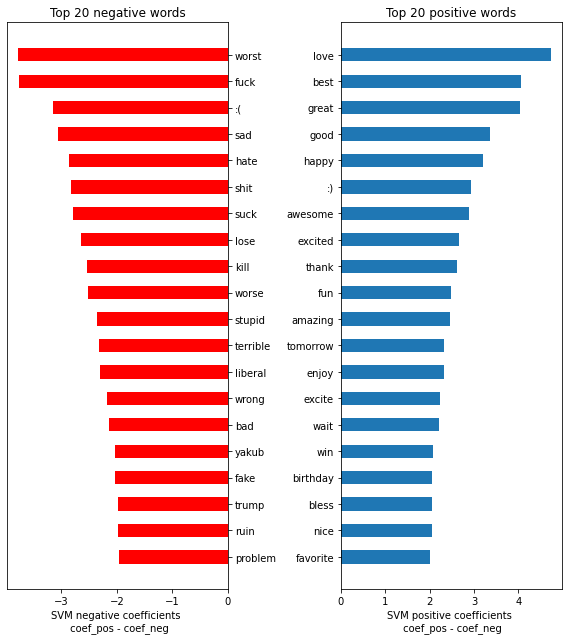

In [19]:
# visualising top 20 negative and positive words based on the SVM coefficients
import matplotlib.pyplot as plt
coefs = []
for i, word in enumerate(vocabulary):
    word_coef = (word, clf.coef_[2,i] - clf.coef_[0,i])
    coefs.append(word_coef)


coefs = sorted(coefs, key=lambda data: data[1], reverse=True)
coefs_topPositive = coefs[0:20]
coefs_topNegative = coefs[-20:]
# print("positive top 20:\n", coefs_topPositive)
# print("negative top 20:\n", coefs_topNegative)

f,a = plt.subplots(1,2, figsize = (8,9))
names = [it[0] for it in coefs_topNegative]
vals = [it[1] for it in coefs_topNegative]

a[0].barh(names, vals, color = 'red', height = 0.5)
a[0].set_xlabel("SVM negative coefficients \n coef_pos - coef_neg"); a[0].set_title("Top 20 negative words")
a[0].yaxis.set_label_position("right")
a[0].yaxis.tick_right()

names = [it[0] for it in coefs_topPositive]
names.reverse()
vals = [it[1] for it in coefs_topPositive]
vals.reverse()
a[1].barh(names, vals, height = 0.5)
a[1].set_xlabel("SVM positive coefficients \n coef_pos - coef_neg"); a[1].set_title("Top 20 positive words")
f.tight_layout()